## Reddit Political Community Analyzer

Reddit is a social media platform that allows users to join and contribute to communities called subreddits. These subreddits can cover a broad range of topics from political debate to memes. User's can view the top aggregated posts from their subreddits in their feed or look at the specific subreddit pages.

Our project is to analyze the political biases of some of reddit’s most popular news-based subreddits. For this project, we chose the subreddits [politics](http://reddit.com/r/politics), [conservative](http://reddit.com/r/conservative), [liberal](http://reddit.com/r/liberal), [moderatepolitics](http://reddit.com/r/moderatepolitics), and [news](http://reddit.com/r/news).

These are among the most popular subreddits for news posts linking to external news sources. politics is the most popular subreddit focused on US political news and frequently has posts that reach the front page. From its description, it would seem as though politics is a neutral source of information, but there has been some [discussion](https://www.reddit.com/r/unpopularopinion/comments/apr96r/reddit_is_a_terrible_site_for_neutral_political/?st=k3xou02x&sh=60e53c3b) that politics is not neutral and heavily leans left. This can misinform some newer users who may stumble upon biased posts thinking they were neutral.

Our goal in this project is to see just how "biased" politics is, compared to the clearly polarized subreddits of liberal and conservative by looking at the news sources linked to in the posts over time. In addition, we will see if there exists a more neutral news subreddit by looking at moderatepolitics and news.

## Similar Work

Reddit is among the most trafficked websites, so there is bound to be similar work to analyze the posts, comments, and users. [Here](https://blog.thedataincubator.com/2018/06/a-study-of-reddit-politics/) is one article that analyzes the politics of Reddit. The author first looked at "month-by-month shared poster data", or data of users who post on multiple subreddits. This approach found some interesting results such as the decreasing number of users who posted to politics and The_Donald (a subreddit devoted to supporting Donald Trump) over time. But, there were a lot of outlier subreddits that appeared such as sport and gaming subreddits. We found this approach interesting but flawed as users who post to a subreddit may be arguing against the main viewpoint and should not necessarily be "clumped" in with those who support the viewpoint, without at least first analyzing the text of the post for its parity.

The author also began a TF-IDF approach to see the popularity of certain political keywords (e.g. healthcare, debate, clinton, bernie) across different subreddits. The key takeaways from this are that certain words appeared a lot more frequently in different subreddits. For example "healthcare" appeared a lot less frequently in /r/The_Donald compared to /r/hillaryclinton and /r/SandersForPresident. We felt that this approach can have its flaws. Sarcasm is very prominent on reddit, so this can throw off some of the analysis of the posts.

In [1]:
import praw
from psaw import PushshiftAPI
from urllib.parse import urlparse
import tldextract
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt

## Reddit Post Scraping

We use Reddit's [API](https://www.reddit.com/dev/api/) using the [PRAW](https://praw.readthedocs.io/en/latest/) Reddit API wrapper. Finally, we used [Pushshift](https://github.com/pushshift/api) which furthered the searching capabilities of Reddit post submissions.

In [2]:
reddit = praw.Reddit(client_id='APP_ID',
                     client_secret='APP_SECRET',
                     user_agent='REDDIT_USERNAME')
api = PushshiftAPI(reddit)

Our general procedure is to extract the top monthly posts from our 5 selected news subreddits. With these posts, we extract the domain of the news source the post links to. Finally, we give the posts a biased rating based on the domain by scraping https://mediabiasfactcheck.com/, one of the most comprehensive media source bias indicators.

We first extract the top (most-upvoted) 50 monthly posts.

In [3]:
# Gets the top monthly posts when given a year (integer), month (1-12), and subreddit
# Returns a list of the submissions as a PRAW Submission object 
def get_top_monthly_posts(year, month, subreddit):
    e_month = month + 1
    e_year = year
    if month == 12:
        e_month = 1
        e_year = year + 1

    start_epoch = int(dt.datetime(year, month, 1).timestamp())
    end_epoch = int(dt.datetime(e_year, e_month, 1). timestamp())
    top_posts = api.search_submissions(before=end_epoch, after=start_epoch,
                                subreddit=subreddit, sort='desc',
                                sort_type='score', limit=50)
    return list(top_posts)

`get_top_monthly_posts` returns a list of PRAW [Submissions](https://praw.readthedocs.io/en/latest/code_overview/models/submission.html). Our interest is just the URL that the post links to.

In [4]:
# Helper method to extract the urls from the list of Submissions
def get_urls(top_posts):
    urls = []
    for post in top_posts:
        urls.append(post.url)
    return urls

Now we extract the domain from the URLs. This process can be very tricky as some URLs have many subdomains. To solve this issue, we used [tldextract](https://github.com/john-kurkowski/tldextract) to extract the domain from the URL. There is still the issue that some of these news subreddits have posts that aren't linked to external news sources. A common one we call megathreads are just text posts meant for discussion. We set these non-news post domains to an empty string. 

Lastly there's a slight edge case where tldextract misinterprets "go" as the domain for "http://abc.go.com/" rather than "abc".

In [5]:
invalid_domains = ['go']
non_news_domains = ['reddit', 'imgur', 'twitter', 'twimg', 'youtube', 'google', 'redd', 'youtu']

def get_url_domain(fullUrl):
    parseObj = tldextract.extract(fullUrl)
    if parseObj.domain in non_news_domains:
        return ""
    elif parseObj.domain in invalid_domains:
        return parseObj.subdomain
    return parseObj.domain

## Getting News Source Biases

For classifying the post news sources, we used https://mediabiasfactcheck.com/. The news sources on the website are classified from Extremely Left, Left, Left-Center, Least Biased, Right-Center, Right, and Extremely Right biased. We were originally planning to search for the media sources, but since the URL domains frequently have abbreviations, this would result in many misses. Luckily, we the webiste provides lists of media sources of a given bias with a slight limitation that there are no lists for Extremely Left and Extremely Right bias, so we had to query those sources manually.

In [6]:
def load_biases(filename):
    least = open(filename, "r").read()
    soup = BeautifulSoup(least, 'html.parser')
    
    sources = set()
    for s in soup.findAll('td', ):
        source = s.string
        if source is not None:
            if source[-1] == ")":
                left_paren = source.find('(')
                sources.add(source[0:left_paren - 1])
                sources.add(get_url_domain(source[left_paren + 1:-1]))
            else:
                sources.add(source)
    return sources

The news source classifications are on a scale from -3 to 3 with -3 corresponding to Extremely Left, 0 with Least-Biased (neutral), and +3 corresponding to Extremely Right. These classifications were then stored in a dictionary mapping news source to political bias score.

We also added additional sources that were extremely left/right biased that we found in the top posts as well as some domains that didn't match up to the websites media source names (e.g. huffpost, buzzfeednews, dailymail, ap, rt).

In [7]:
# Loading the biases to a dict mapping (source/website to bias ranking)
left =         load_biases("Left.htm")
left_center =  load_biases("Left-Center.htm")
least =        load_biases("Least.htm")
right_center = load_biases("Right-Center.htm")
right =        load_biases("Right.htm")

biases = {}

biases.update(biases.fromkeys(left,        -2))
biases.update(biases.fromkeys(left_center, -1))
biases.update(biases.fromkeys(least,        0))
biases.update(biases.fromkeys(right_center, 1))
biases.update(biases.fromkeys(right,        2))

del biases[""]  # sometimes the parsing gets an empty line for the news source

addenum_to_biases = {"huffpost" : -2, 
                     "buzzfeednews" : -1, 
                     "breitbart" : 3, 
                     "progressivestoday" : 3, 
                     "frontpagemag" : 3,
                     "dailymail" : 2,
                     "ap" : 0,
                     "sputniknews" : 2,
                     "truthinmedia" : 3,
                     "resistancereport" : -3,
                     "redstate" : 2,
                     "newcenturytimes" : -3,
                     "rare" : 1,
                     "rt" : 1,
                     "americanthinker" : 3,
                     "cnsnews" : 3
                    }
biases.update(addenum_to_biases)

## Putting it All Together

Now that we have the biases, we can start to process the monthly posts from each of the subreddits. The `get_monthly_bias` function takes in the year (integer), month (1-12) and subreddit of interest and outputs the
* total score of all parseable posts with a domain in bias list
* total number of parseable posts
* bias breakdown (i.e. how many of each type of media source)
* sources for all of the parseable posts

The reason we have to also compute the total number of parseable posts is that some of the remaining news sources domains are not in the media bias website database. These are frequently local news websites that do not have an entry in the website. Other cases are just posts that don't link to external news sources.

In [8]:
START_YEAR = 2016
CURRENT_YEAR = 2019

def get_monthly_bias(year, month, subreddit):
    top_monthly_posts = get_top_monthly_posts(year, month, subreddit)
    top_monthly_urls = get_urls(top_monthly_posts)
    score = 0
    total_num_parseable = 0
    bias_breakdown = {}
    bias_breakdown.update(bias_breakdown.fromkeys([-3, -2, -1, 0, 1, 2, 3], 0))

    out_sources = []
    
    for url in top_monthly_urls:
        parsed_url = get_url_domain(url)
        total_num_parseable += 1
        if parsed_url != "":
            if parsed_url in biases:
                bias = biases.get(parsed_url)
                score += bias
                bias_breakdown[bias] += 1
                out_sources.append(parsed_url)
            else:
                total_num_parseable -= 1
    return (score, total_num_parseable, bias_breakdown, out_sources)

def get_all_biases(year, subreddit):
    totals = []
    parseables = []
    bias_breakdowns = []
    out_sources_overall = []
    for i in range(CURRENT_YEAR - year + 1):
        for month in range(12):
            (total, parseable, bias_breakdown, out_s) = get_monthly_bias(year + i, month + 1, subreddit)
            totals.append(total)
            parseables.append(parseable)
            bias_breakdowns.append(bias_breakdown)
            out_sources_overall += out_s
    return (totals, parseables, bias_breakdowns, out_sources_overall)

(tot_politics, num_politics, b_politics, os_politics) = get_all_biases(START_YEAR, "politics")
(tot_Conservative, num_Conservative, b_Conservative, os_Conservative) = get_all_biases(START_YEAR, "Conservative")
(tot_Liberal, num_Liberal, b_Liberal, os_Liberal) = get_all_biases(START_YEAR, "Liberal")
(tot_moderatepolitics, num_moderatepolitics, b_moderatepolitics, os_moderatepolitics) = get_all_biases(START_YEAR, "moderatepolitics")
(tot_news, num_news, b_news, os_news) = get_all_biases(START_YEAR, "news")

## Analysis

Now that we have the monthly scores, number of parseable posts, score breakdowns, and the sources, we can start to visualize the data!

In [9]:
dates = []

# Create an array for the dates to be used as the x-axis in the time-scale
for y in range(2016, 2020):
    for month in range(1, 13):
        m_str = str(month)
        if month < 10:
            m_str = "0" + m_str
        dates.append(str(y) + "-" + m_str)
dates = np.array(dates, dtype='datetime64')

# Create score for visualizations that is:
#   total monthly score / total number parseable
politics_score = np.divide(np.array(tot_politics), np.array(num_politics))
conservative_score = np.divide(np.array(tot_Conservative), np.array(num_Conservative))
liberal_score = np.divide(np.array(tot_Liberal), np.array(num_Liberal))
moderatepolitics_score = np.divide(np.array(tot_moderatepolitics), np.array(num_moderatepolitics))
news_score = np.divide(np.array(tot_news), np.array(num_news))

# Dataframe to store our monthly scores and dates
df_all_subreddits = pd.DataFrame({'dates' : dates, 
                                  'politics' : politics_score,
                                  'conservative' : conservative_score,
                                  'liberal' : liberal_score,
                                  'moderatepolitics' : moderatepolitics_score,
                                  'news' : news_score})


We first want to visualize how politics compares to the more polarized subreddits of liberal (left) and conservative (right). Here, we plot the political bias scores over time.

/usr/local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


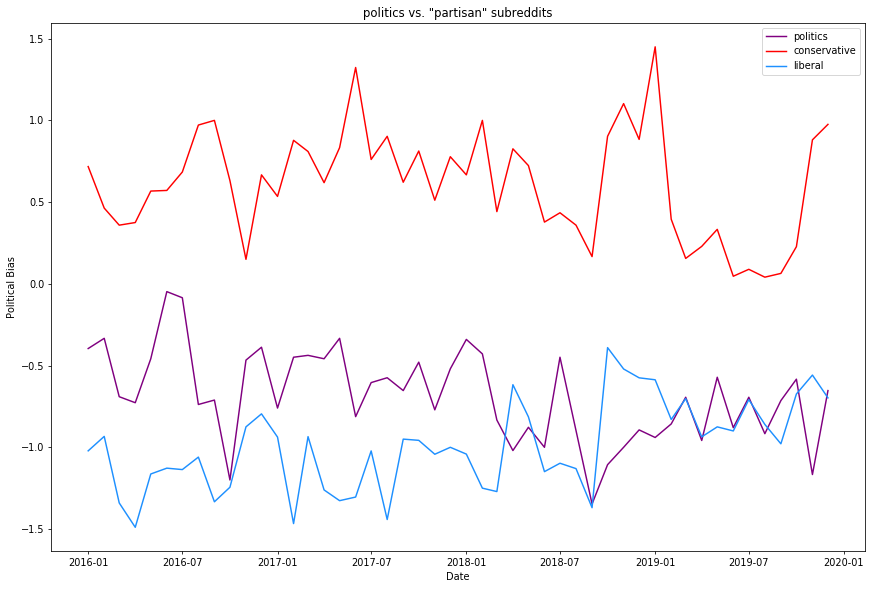

In [10]:
fig = plt.figure(figsize=(15, 10), dpi=70)
plt.plot('dates', 'politics', data=df_all_subreddits, color ='purple')
plt.plot('dates', 'conservative', data=df_all_subreddits, color='red')
plt.plot('dates', 'liberal', data=df_all_subreddits, color='dodgerblue')
plt.xlabel('Date')
plt.ylabel('Political Bias')
plt.title('politics vs. "partisan" subreddits')
plt.legend()

From this plot, we can gather that Liberal and Conservative clearly use different biased sources. At the start of our plot, politics is slightly left leaning but gradually shifts to become more left-leaning and aligned with Liberal. In some months (end of 2018), politics has more left-leaning bias than even liberal! Lastly, we note that the two biggest shifts to the left for politics occur in November 2016 and October 2018, which happen to be around election months.

Next, we look at how politics compares to the more supposedly neutral subreddits of moderatepolitics and news.

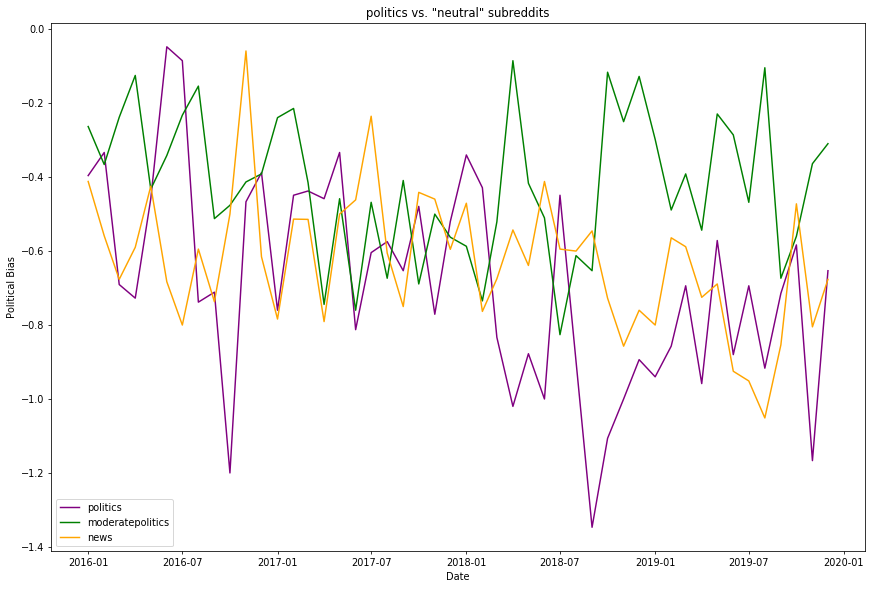

In [11]:
fig = plt.figure(figsize=(15, 10), dpi=70)
plt.plot('dates', 'politics', data=df_all_subreddits, color ='purple')
plt.plot('dates', 'moderatepolitics', data=df_all_subreddits, color='green')
plt.plot('dates', 'news', data=df_all_subreddits, color='orange')
plt.xlabel('Date')
plt.ylabel('Political Bias')
plt.title('politics vs. "neutral" subreddits')
plt.legend()

From this plot, we can see that all three subreddits' news sources have some left-leaning bias with politics slightly more left than the others. moderatepolitics seems to be more neutral and not aligned with politics' trend. Also we can see that in the months leading up to major US elections, the subreddits appear to become more polarized.

The past two graphs give a general outlook on the subreddits' source bias and how they have changed over time. Now, let's dive deep into the bias breakdowns!

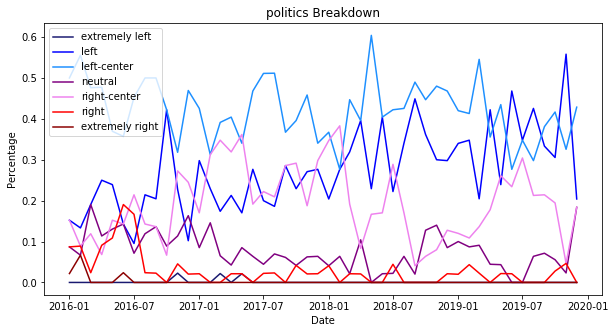

In [12]:
def plot_bias_breakdown(breakdown, title):
    pol_test = np.ndarray((48, 7), np.float64) # 4 years * 12 months per year = 48
                                               # 7 classification values
    for index in range(len(breakdown)):
        num_parseable = 0
        for i in range(7):
            num_parseable += (breakdown[index])[i - 3]
        for i in range(7):
            pol_test[index][i] = (breakdown[index])[i - 3] / num_parseable
    fig = plt.figure(figsize=(10, 5))
    pol_test = pol_test.T
    plt.plot(dates, pol_test[0], label="extremely left", color='midnightblue')
    plt.plot(dates, pol_test[1], label="left", color='blue')
    plt.plot(dates, pol_test[2], label="left-center", color='dodgerblue')
    plt.plot(dates, pol_test[3], label="neutral", color='purple')
    plt.plot(dates, pol_test[4], label="right-center", color='violet')
    plt.plot(dates, pol_test[5], label="right", color='red')
    plt.plot(dates, pol_test[6], label="extremely right", color='darkred')
    plt.xlabel('Date')
    plt.ylabel('Percentage')
    plt.title(title)
    plt.legend()

plot_bias_breakdown(b_politics, "politics Breakdown")

politics heavily uses sources from the left-center and left with few sources taken from the extremes or right. At the start of 2016, there were actually a few extremely right news source posts that were among the top posts, but after late 2016 there were none. Over time, the top posts have trended to use more left sources rather than right-center as seen by the dip between late 2018 and mid 2019.

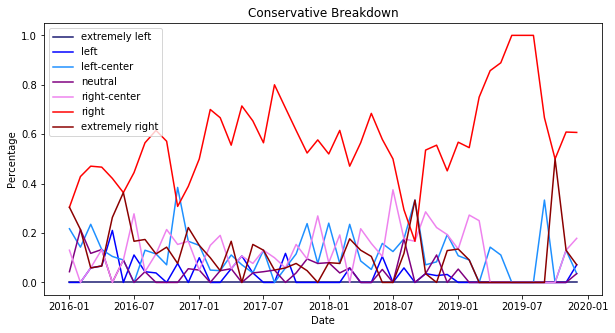

In [13]:
plot_bias_breakdown(b_Conservative, "Conservative Breakdown")

Conservative heavily uses right news sources and not many others. In some months in 2019, all the posts even come from right news sources. Unsurprisingly, Conservative still uses some extremely right sources, and uses significantly less left sources than politics.

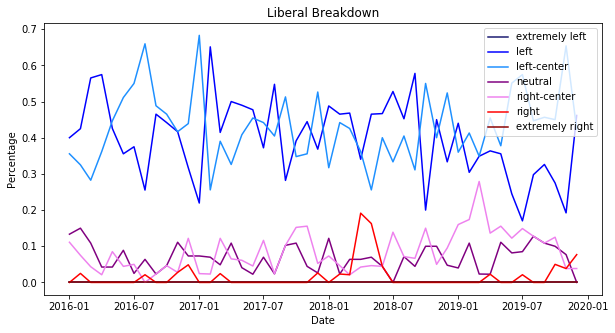

In [14]:
plot_bias_breakdown(b_Liberal, "Liberal Breakdown")

liberal uses predominately left and left-center sources. It was surprising that the Liberal subreddit still used some posts from right-center and right news sources. Lastly, from mid 2018 onwards, it seems like the top posts in liberal shifted to use more left-center rather than left sources.

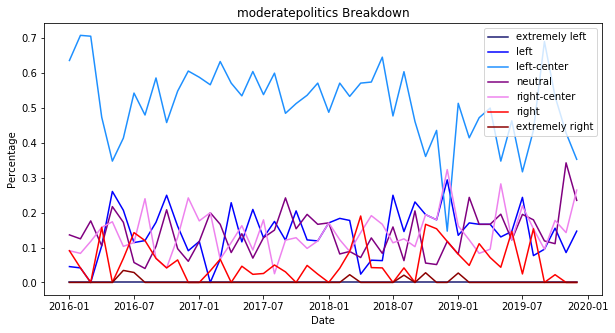

In [15]:
plot_bias_breakdown(b_moderatepolitics, "moderatepolitics Breakdown")

moderatepolitics uses the most sources with a slight left/right bias, but the sources are predominately left-center. Also, the number of left sources is almost always above the right counterpart.

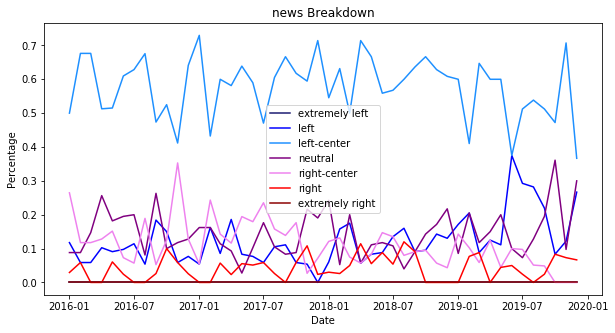

In [16]:
plot_bias_breakdown(b_news, "news Breakdown")

news follows a similar trend with moderatepolitics, but uses more right-center sources in general than left sources.

Lastly, we show the most common news sources.

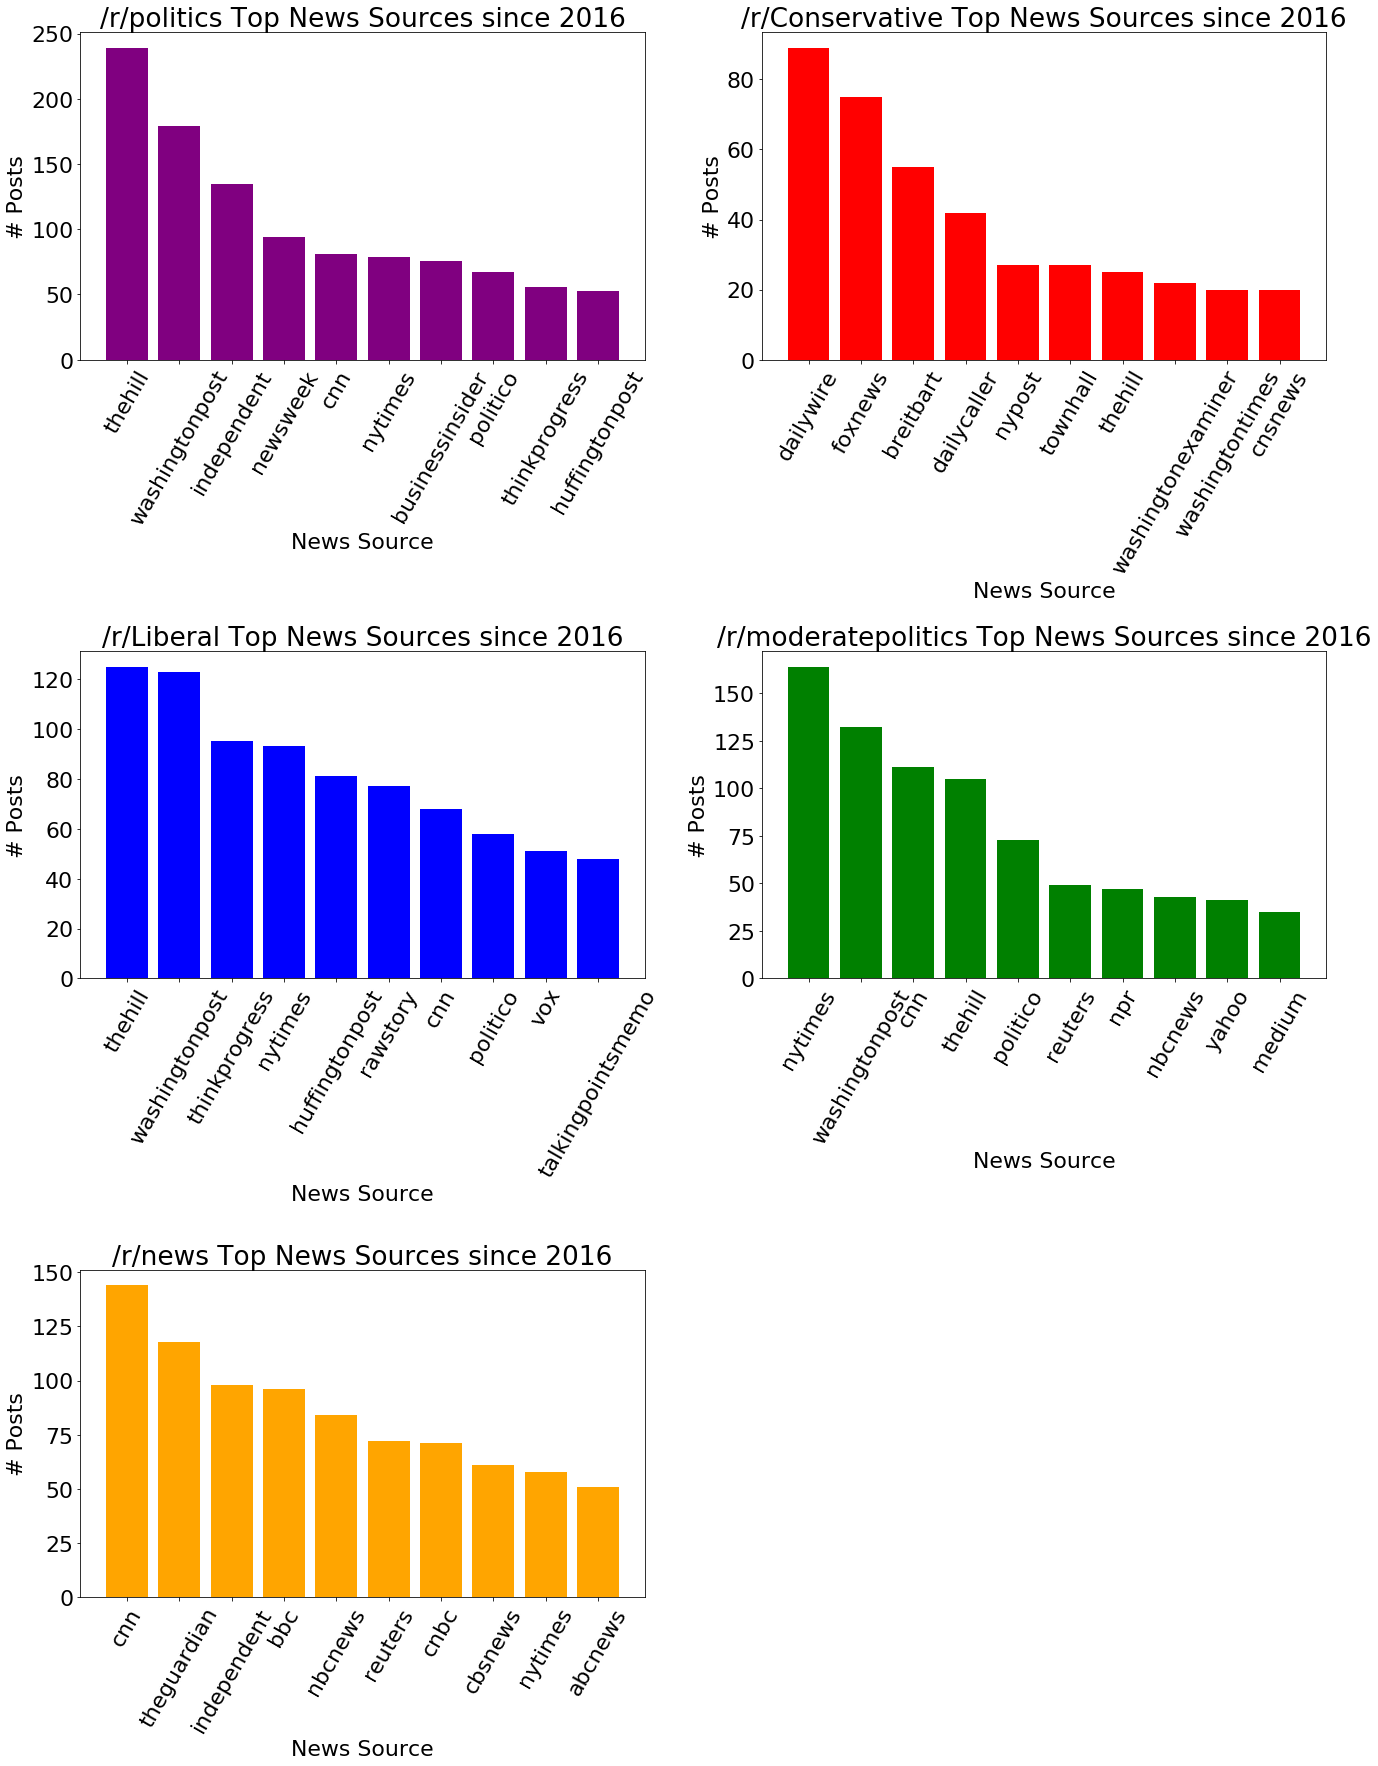

In [17]:
from collections import Counter
def most_common_sources(os_subreddit, title, col, i):
    plt.subplot(i)
    w = dict(Counter(os_subreddit).most_common(10))
    plt.xticks(rotation=60)
    plt.bar(*zip(*w.items()), color=col, align='center')
    plt.title(title)
    plt.xlabel('News Source')
    plt.ylabel('# Posts')
    plt.plot()
    
plt.rcParams.update({'font.size': 22})

fig = plt.figure(figsize=(20, 25))
most_common_sources(os_politics, '/r/politics Top News Sources since 2016', 'purple', 321)
most_common_sources(os_Conservative, '/r/Conservative Top News Sources since 2016', 'red', 322)
most_common_sources(os_Liberal, '/r/Liberal Top News Sources since 2016', 'blue', 323)
most_common_sources(os_moderatepolitics, '/r/moderatepolitics Top News Sources since 2016', 'green', 324)
most_common_sources(os_news, '/r/news Top News Sources since 2016', 'orange', 325)

fig.tight_layout()

We can see that liberal, politics, and moderatepolitics share many of the same news sources (e.g. thehill, washingtonpost, nytimes), while Conservative features some of the most right-biased sources (e.g. dailywire, foxnews, breitbart). news features some crossover with the more left-leaning subreddits, but features media sources that have an international presence like cnn, theguardian, independent, and bbc.

## Conclusions

Through our project, we've found that no subreddit uses completely unbiased sources. The most popular US political subreddit, politics, in particular uses sources that increasingly lean left-center. What surprised us the most is that politics has had months that were even more left than the Liberal subreddit. This is slightly alarming as unknowing users of reddit, who try to engage in debate on this subreddit may be downvoted/criticized for a non-left opinion. Additionally, taking politics as a neutral source can lead to more misinformation in today's "Fake News" era.

Of all the subreddits we analyzed, moderatepolitics appears the most unbiased overall and uses the most neutral sources.

## Future Work

This is certainly an interesting subject matter in today's polarized political landscape. To gather the bias ratings, we used https://mediabiasfactcheck.com/, which has some limitations. Many of the top posts that we could not assign a political bias towards were from local news outlets that had no entry on the website. For future similar analysis, we should do more research into how these local outlets lean. Alternatively, we could build a classifier for the news stories themselves, looking at the text and/or author's background to classify posts.

We had also looked into the effects of major news stories on the political subreddits. For instance, around elections, we noticed the political biases became more polarized. Around the start of the House impeachment proceedings around November 2019, politics became more left, while conservative became a lot more right. More research can be done to see how major news events affect community posts, subscriber counts, and user demographics.

Next, we noticed that https://mediabiasfactcheck.com/ also provides factual reporting scales for many news sources. So we could also analyze how certain use subreddits link to factual news sources.